# import library

In [ ]:
import zipfile, os
import shutil
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


from sklearn.metrics import classification_report, confusion_matrix

# download data

In [ ]:
#unduh data
!gdown 1cJoKwJNk7VxD_SxKd509lTFZlwXqcGxn

Downloading...
From (original): https://drive.google.com/uc?id=1cJoKwJNk7VxD_SxKd509lTFZlwXqcGxn
From (redirected): https://drive.google.com/uc?id=1cJoKwJNk7VxD_SxKd509lTFZlwXqcGxn&confirm=t&uuid=03ee7821-ba58-45ff-b88e-abb55b0e3fe7
To: /content/dataset_cotton.zip
100% 4.27G/4.27G [01:04<00:00, 66.1MB/s]


In [ ]:
# unzip data
!unzip '/content/dataset_cotton.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/contrast_9.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_1.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_10.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_11.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_12.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_13.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_14.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_15.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_16.jpeg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_17.jpg  
  inflating: Main dataset-20230209T170929Z-001/Main dataset/Healthy/crop_18.jpg  
  inflating: Main dataset-20230209T170929Z-0

# split dataset

In [ ]:
# membuat variabel untuk data path
data_path = '/content/Main dataset-20230209T191052Z-001/Main dataset'

In [ ]:
# membuat folder train test dan validation
os.mkdir('train')
os.mkdir('test')
os.mkdir('validation')

In [ ]:
# membagi data menjadi tiga folder secara acak

from sklearn.model_selection import train_test_split

def move_data(data_path, train_ratio=0.75, val_ratio=0.15, test_ratio=0.1):
    """
    Memindahkan dataset menuju train, test, and validation.

    Args:
        data_path: Path menuju direktori dataset utama.
        train_ratio: Rasio data training set
        val_ratio: Rasio data validation set
        test_ratio: Rasio data test set

    Raises:
        ValueError: jika total rasio tidak 1.
    """

    # Memastikan total jumlah rasio 1
    if train_ratio + val_ratio + test_ratio != 1:
        raise ValueError("Sum of train, validation, and test ratios must be equal to 1.")

    # Menginisialisasi variabel untuk menyimpan jalur direktori masing-masing folder dataset
    train_dir = '/content/train'
    val_dir = '/content/validation'
    test_dir = '/content/test'

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for label_dir in os.listdir(data_path):
        # Memperoleh kelas keseluruhan
        label_path = os.path.join(data_path, label_dir)

        # Check if it's a directory and not a file
        if os.path.isdir(label_path):
            # Membagi data berdasarkan label
            data_files = os.listdir(label_path)
            train_files, remaining_files = train_test_split(data_files, test_size=1 - train_ratio, random_state=None)
            val_files, test_files = train_test_split(remaining_files, test_size=test_ratio / (val_ratio + test_ratio), random_state=None)

            # Membuat subfolder untuk setiap label pada direktori train, test, dan validation
            os.makedirs(os.path.join(train_dir, label_dir), exist_ok=True)
            os.makedirs(os.path.join(val_dir, label_dir), exist_ok=True)
            os.makedirs(os.path.join(test_dir, label_dir), exist_ok=True)

            # Memindahkan file ke dalam sub folder masing-masing
            for file in train_files:
                shutil.move(os.path.join(label_path, file), os.path.join(train_dir, label_dir, file))
            for file in val_files:
                shutil.move(os.path.join(label_path, file), os.path.join(val_dir, label_dir, file))
            for file in test_files:
                shutil.move(os.path.join(label_path, file), os.path.join(test_dir, label_dir, file))

# inisialisasi data path
data_path = "/content/Main dataset-20230209T191052Z-001/Main dataset"
move_data(data_path)


# image data generator

In [ ]:
# inisialisasi variabel
size = (120, 120)
batch = 16
train_dir = '/content/train'
test_dir = '/content/test'
validation_dir = '/content/validation'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255)

test_datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
# Menginisialisasi objek ImageDataGenerator untuk augmentasi dan preprocessing data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale = 1./255,         # Normalisasi piksel gambar dari rentang [0, 255] menjadi [0, 1]
    shear_range=0.2,          # Mengaplikasikan transformasi geser dengan rentang 0.2
    rotation_range=20,        # Memutar gambar dalam rentang 20 derajat untuk variasi
    zoom_range=0.2,           # Memperbesar atau memperkecil gambar dalam rentang 0.2
    horizontal_flip=True,     # Membalik gambar secara horizontal untuk variasi tambahan
)

# Menginisialisasi objek ImageDataGenerator untuk normalisasi data pada set validasi
validation_datagen = ImageDataGenerator(
    rescale=1./255            # Normalisasi piksel gambar dari rentang [0, 255] menjadi [0, 1]
)

# Menginisialisasi objek ImageDataGenerator untuk normalisasi data pada set pengujian
test_datagen = ImageDataGenerator(
    rescale=1./255            # Normalisasi piksel gambar dari rentang [0, 255] menjadi [0, 1]
)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=size,
    batch_size= batch,
    class_mode='categorical',
    subset='training',
    classes = ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
)

Found 2700 images belonging to 6 classes.


In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=size,
    batch_size= batch,
    class_mode='categorical',
    shuffle=False,
    classes=['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']
)


Found 540 images belonging to 6 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=size,
    batch_size= batch,
    class_mode='categorical',
    classes=['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot'],
    shuffle = False
)


Found 361 images belonging to 6 classes.


# Info Dataset

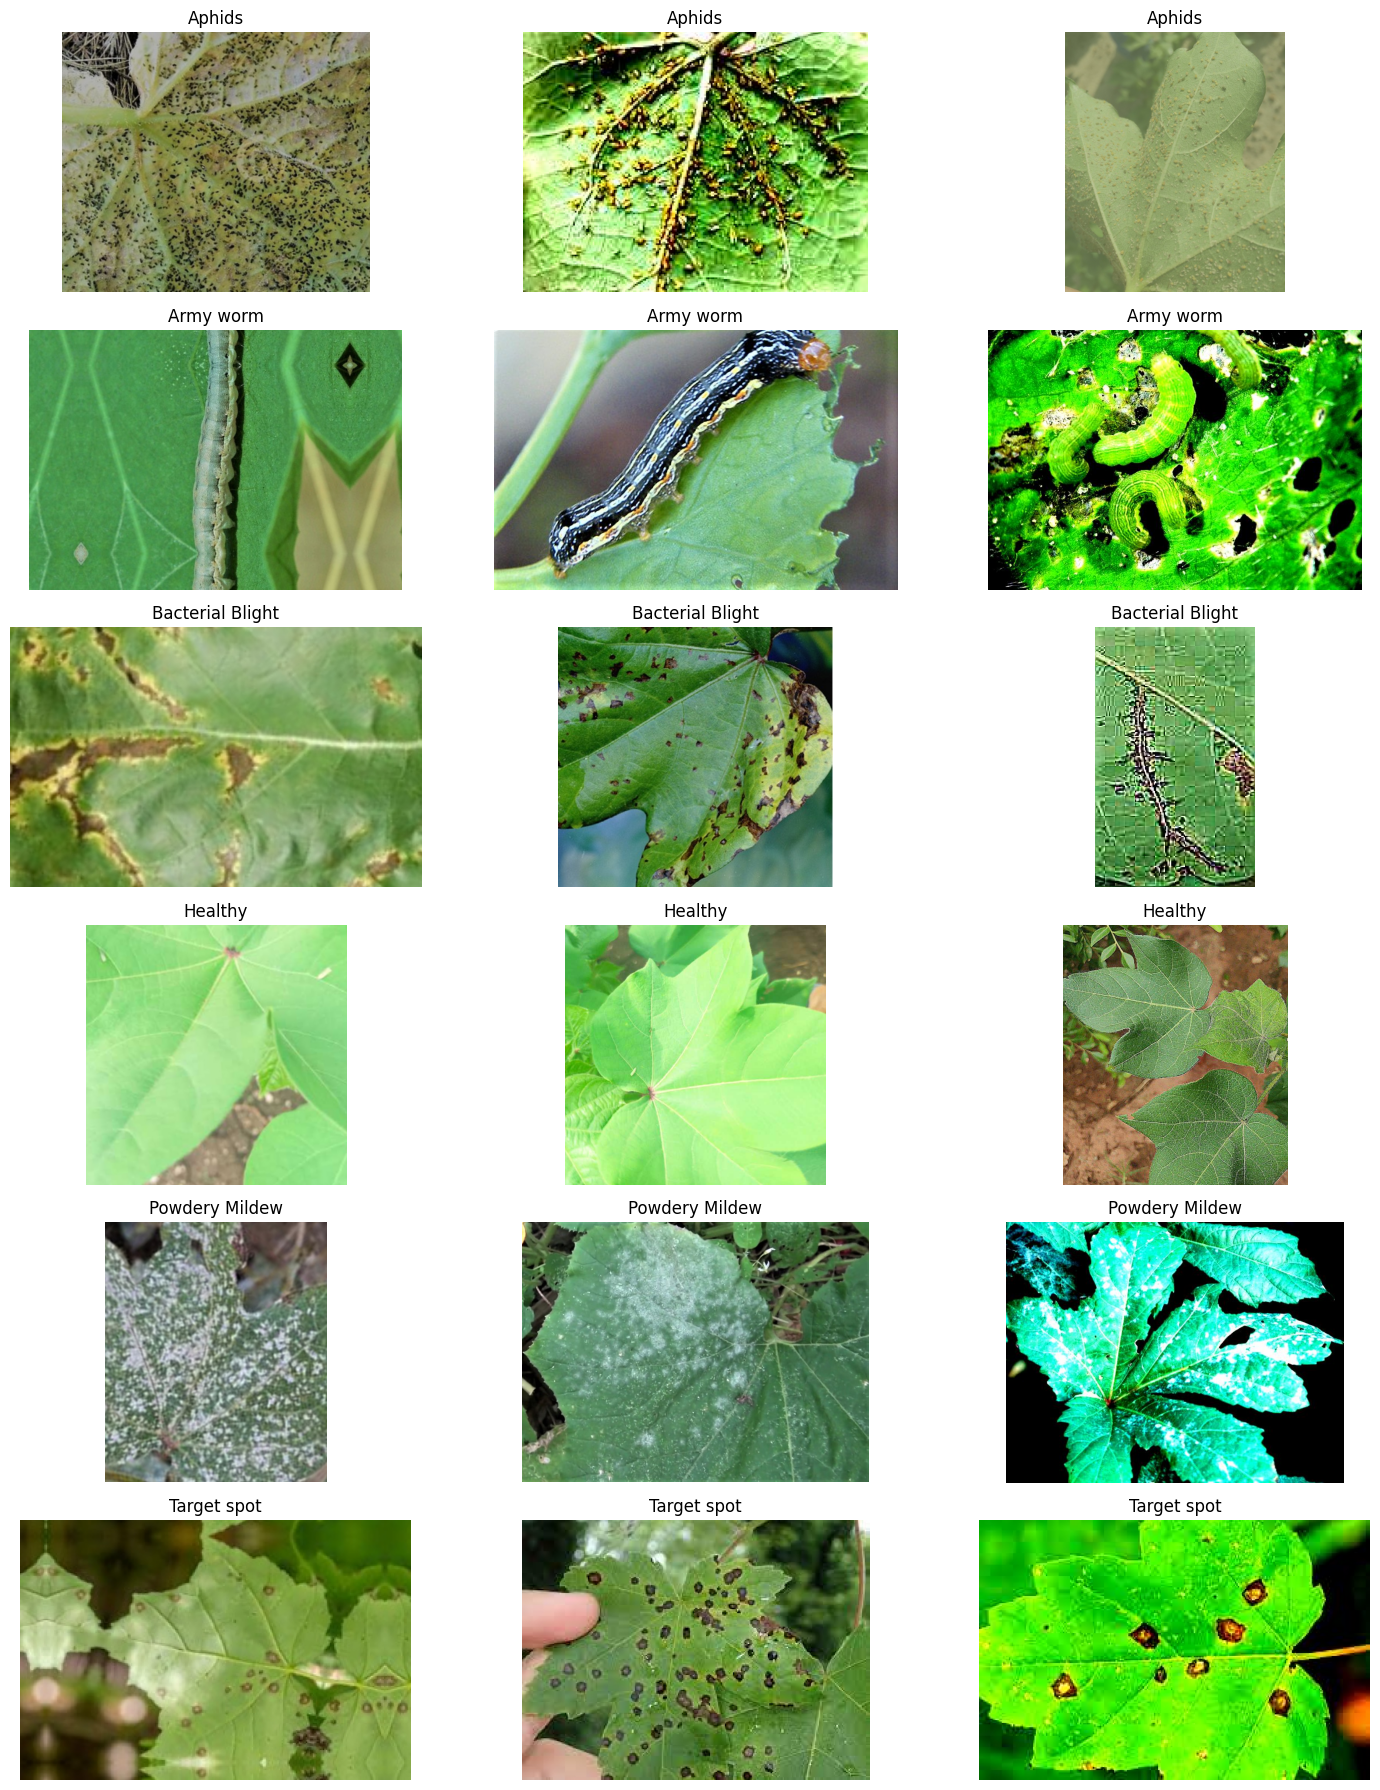

In [ ]:
#visualisasi gambar
dataset_path = "/content/train"

# Jumlah sampel per label
num_samples_per_label = 3

# memastikan lokasi dataset
if not os.path.exists(dataset_path):
    print("Error: Dataset path", dataset_path, "does not exist.")
    exit(1)

labels = ["Aphids", "Army worm", "Bacterial Blight", "Healthy", "Powdery Mildew", "Target spot"]
for label in labels:
    label_path = os.path.join(dataset_path, label)
    if not os.path.isdir(label_path):
        print("Error: Label folder", label_path, "does not exist.")
        exit(1)

    # Pengecekan apakah data ada atau tidak
    image_files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]
    if len(image_files) < num_samples_per_label:
        print("Warning:", label, "folder has less than", num_samples_per_label, "images. Using available images.")
        num_samples_per_label = len(image_files)  # Adjust based on available images

# menciptakan 6x3 layout
rows, cols = 6, 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 18))  # Adjust figure size for better visualization

# menampilkan gambar
index = 0
for label in labels:
    label_path = os.path.join(dataset_path, label)
    image_files = [os.path.join(label_path, f) for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]

    for i in range(num_samples_per_label):
        if i >= len(image_files):
            break

        image = plt.imread(image_files[i])
        axes[index // cols, index % cols].imshow(image)
        axes[index // cols, index % cols].set_title(label)
        axes[index // cols, index % cols].axis('off')
        index += 1

plt.tight_layout()
plt.show()

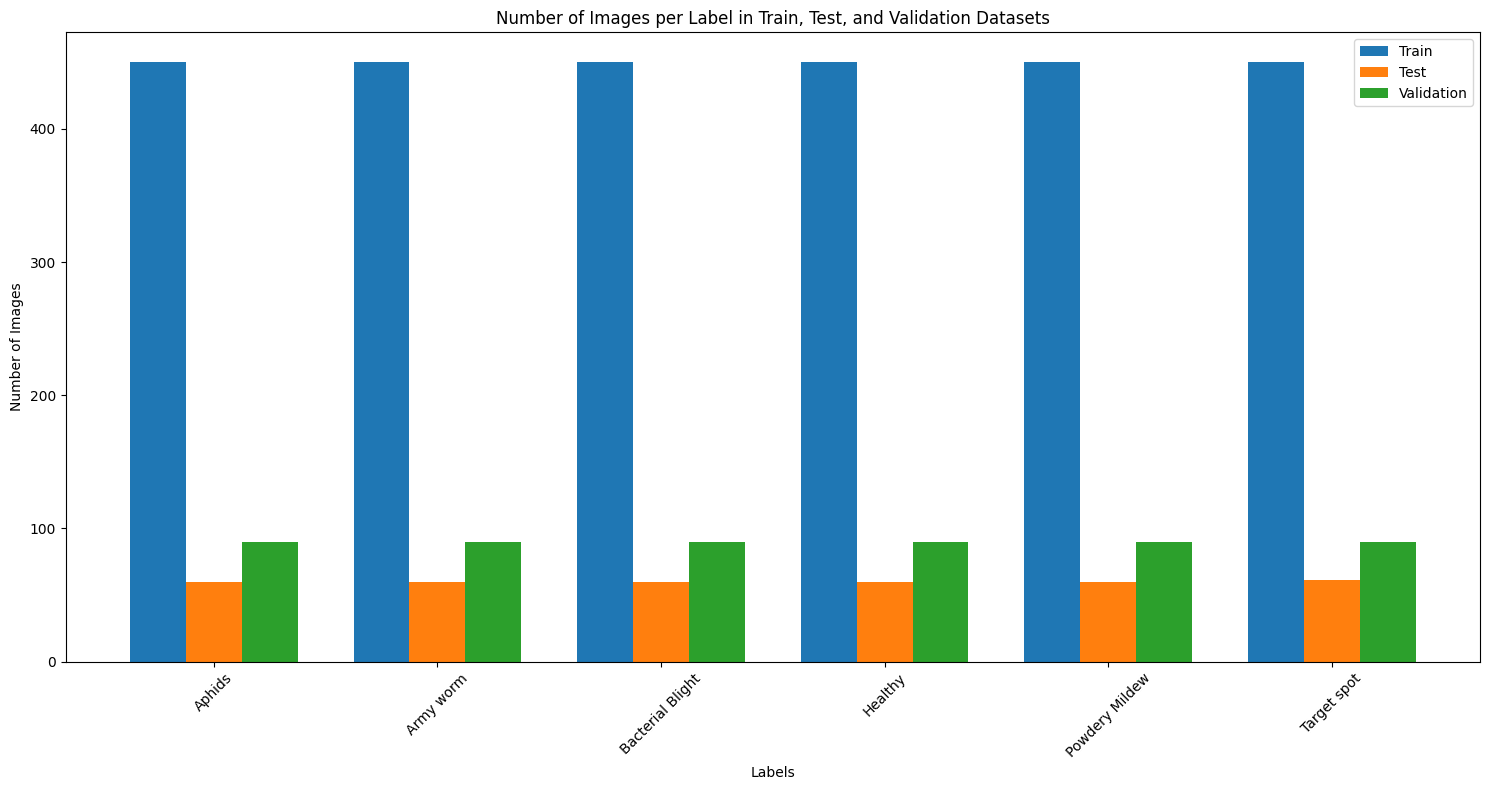

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the labels
labels = ["Aphids", "Army worm", "Bacterial Blight", "Healthy", "Powdery Mildew", "Target spot"]

# Function to count images in each label folder
def count_images(directory, labels):
    label_counts = {}
    for label in labels:
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            label_counts[label] = len(os.listdir(label_path))
        else:
            label_counts[label] = 0
    return label_counts

# Count images in each dataset
train_counts = count_images(train_dir, labels)
test_counts = count_images(test_dir, labels)
validation_counts = count_images(validation_dir, labels)

# Prepare data for plotting
sorted_labels = sorted(labels)

train_values = [train_counts[label] for label in sorted_labels]
test_values = [test_counts[label] for label in sorted_labels]
validation_values = [validation_counts[label] for label in sorted_labels]

# Plotting the bar chart
x = range(len(sorted_labels))
bar_width = 0.25

plt.figure(figsize=(15, 8))

plt.bar(x, train_values, width=bar_width, label='Train', align='center')
plt.bar([p + bar_width for p in x], test_values, width=bar_width, label='Test', align='center')
plt.bar([p + bar_width*2 for p in x], validation_values, width=bar_width, label='Validation', align='center')

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label in Train, Test, and Validation Datasets')
plt.xticks([p + bar_width for p in x], sorted_labels, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


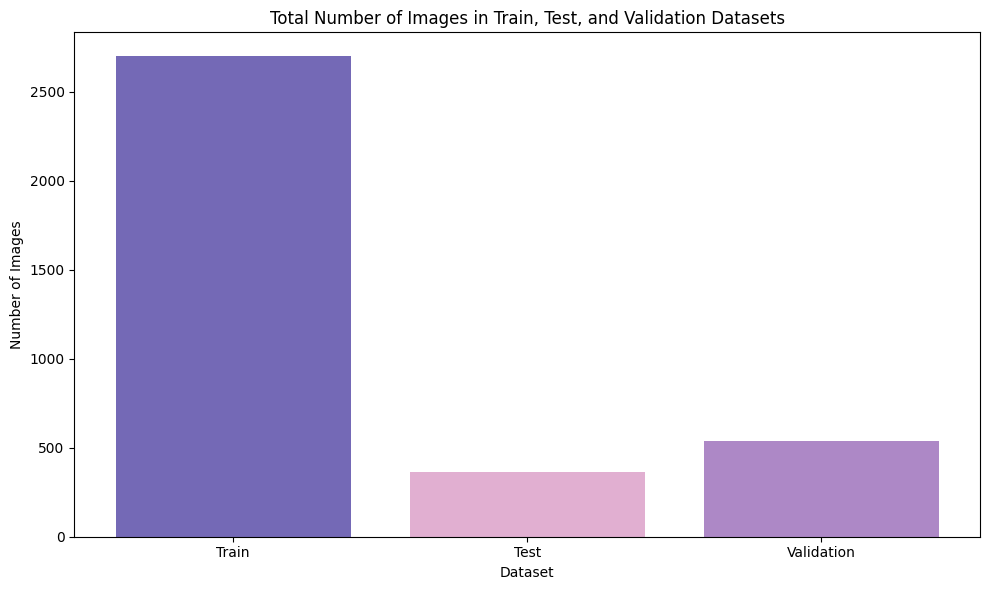

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the paths to the datasets
train_dir = '/content/train'
test_dir = '/content/test'
validation_dir = '/content/validation'

# Function to count all images in a directory (including subdirectories)
def count_all_images(directory):
    total_count = 0
    for subdir, _, files in os.walk(directory):
        total_count += len(files)
    return total_count

# Count total images in each dataset
train_count = count_all_images(train_dir)
test_count = count_all_images(test_dir)
validation_count = count_all_images(validation_dir)

# Data for plotting
datasets = ['Train', 'Test', 'Validation']
counts = [train_count, test_count, validation_count]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(datasets, counts, color=['#7469B6', '#E1AFD1', '#AD88C6'])

# Adding labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Total Number of Images in Train, Test, and Validation Datasets')

# Show the plot
plt.tight_layout()
plt.show()


# modelling

In [ ]:
model = keras.Sequential([
    # bagian feature learning
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(120, 120, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    # bagian klasifikasi
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(6, activation='softmax')
])

In [ ]:
# menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0

In [ ]:
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')> 0.95):
      print("\nAkurasi telah mencapai 95%, hentikan training!")
      self.model.stop_training = True

callbacks = myCallback()


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
model.compile(optimizer= optimizers.Adam(learning_rate = 0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy', Recall()])

history = model.fit(train_generator,
                    epochs=25,
                    validation_data = validation_generator,
                    callbacks = [callbacks, early_stopping],
                    verbose = 1)

Epoch 1/25
169/169 [==============================] - 134s 776ms/step - loss: 1.5520 - accuracy: 0.3681 - recall: 0.1019 - val_loss: 1.1802 - val_accuracy: 0.5537 - val_recall: 0.3815
Epoch 2/25
169/169 [==============================] - 130s 767ms/step - loss: 1.1437 - accuracy: 0.5589 - recall: 0.3626 - val_loss: 1.0967 - val_accuracy: 0.5667 - val_recall: 0.4630
Epoch 3/25
169/169 [==============================] - 135s 795ms/step - loss: 0.9680 - accuracy: 0.6378 - recall: 0.4811 - val_loss: 0.7869 - val_accuracy: 0.7093 - val_recall: 0.5481
Epoch 4/25
169/169 [==============================] - 130s 766ms/step - loss: 0.8322 - accuracy: 0.6919 - recall: 0.5767 - val_loss: 0.6939 - val_accuracy: 0.7537 - val_recall: 0.6167
Epoch 5/25
169/169 [==============================] - 133s 785ms/step - loss: 0.7688 - accuracy: 0.7141 - recall: 0.6159 - val_loss: 0.6825 - val_accuracy: 0.7426 - val_recall: 0.6537
Epoch 6/25
169/169 [==============================] - 128s 753ms/step - loss: 0.

# evaluasi

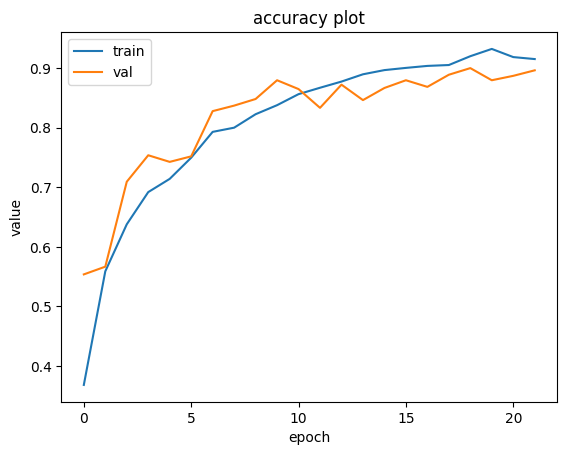

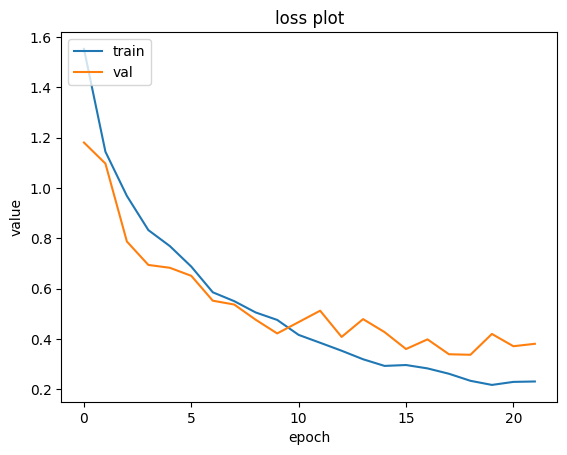

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy plot')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss plot')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# test model

In [ ]:
# cetak kelas dan indeksnya
print("Class indices in test generator:", test_generator.class_indices)
print("Classes in test set:", np.unique(test_generator.classes))

Class indices in test generator: {'Aphids': 0, 'Army worm': 1, 'Bacterial Blight': 2, 'Healthy': 3, 'Powdery Mildew': 4, 'Target spot': 5}
Classes in test set: [0 1 2 3 4 5]


In [ ]:
# cetak jumlah data dalam tes setiap gambar
for class_name in ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']:
    class_path = os.path.join(test_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))} images")


Aphids: 60 images
Army worm: 60 images
Bacterial Blight: 60 images
Healthy: 60 images
Powdery Mildew: 60 images
Target spot: 61 images


In [ ]:
for class_name in ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']:
    class_path = os.path.join(validation_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))} images")

Aphids: 90 images
Army worm: 90 images
Bacterial Blight: 90 images
Healthy: 90 images
Powdery Mildew: 90 images
Target spot: 90 images


In [ ]:
for class_name in ['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']:
    class_path = os.path.join(train_dir, class_name)
    print(f"{class_name}: {len(os.listdir(class_path))} images")

Aphids: 450 images
Army worm: 450 images
Bacterial Blight: 450 images
Healthy: 450 images
Powdery Mildew: 450 images
Target spot: 450 images


In [ ]:
# prediksi data baru
predictions = model.predict(test_generator)

23/23 [==============================] - 5s 212ms/step


In [ ]:
# menampilkan hasil klasifikasi data tes
y_true = test_generator.classes
print(classification_report(y_true, predictions.argmax(axis=1)))
print(confusion_matrix(y_true, predictions.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.91      0.88      0.90        60
           1       0.89      0.93      0.91        60
           2       0.88      0.88      0.88        60
           3       0.90      1.00      0.94        60
           4       1.00      0.93      0.97        60
           5       0.91      0.85      0.88        61

    accuracy                           0.91       361
   macro avg       0.92      0.91      0.91       361
weighted avg       0.92      0.91      0.91       361

[[53  3  2  0  0  2]
 [ 1 56  2  1  0  0]
 [ 3  0 53  1  0  3]
 [ 0  0  0 60  0  0]
 [ 0  2  1  1 56  0]
 [ 1  2  2  4  0 52]]


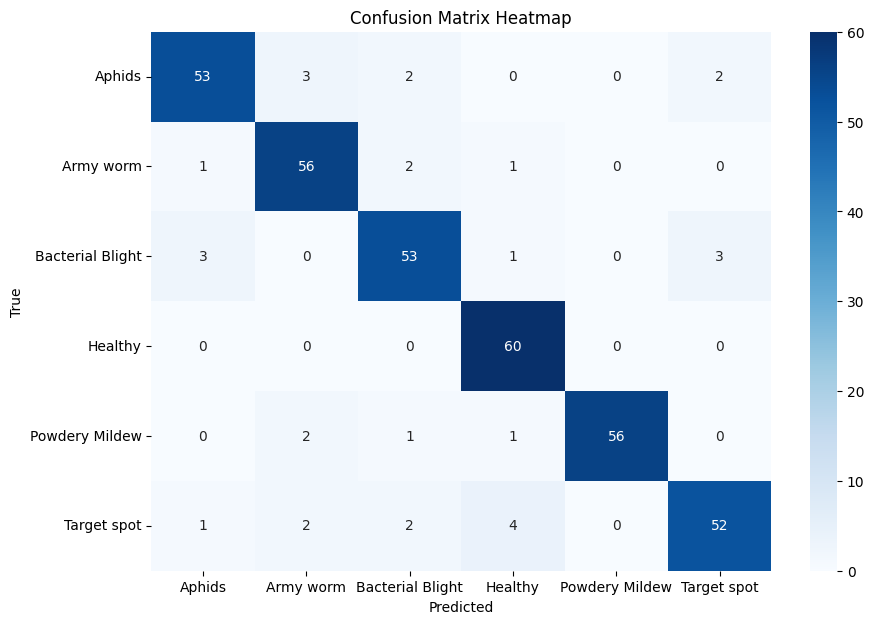

                  precision    recall  f1-score   support

          Aphids       0.91      0.88      0.90        60
       Army worm       0.89      0.93      0.91        60
Bacterial Blight       0.88      0.88      0.88        60
         Healthy       0.90      1.00      0.94        60
  Powdery Mildew       1.00      0.93      0.97        60
     Target spot       0.91      0.85      0.88        61

        accuracy                           0.91       361
       macro avg       0.92      0.91      0.91       361
    weighted avg       0.92      0.91      0.91       361



In [ ]:
import seaborn as sns

# Inisialisasi variabel prediksi dan nilai sebenarnya
y_true = test_generator.classes
y_pred = predictions.argmax(axis=1)

# Kalkulasi dengan confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Definisi label
labels = ["Aphids", "Army worm", "Bacterial Blight", "Healthy", "Powdery Mildew", "Target spot"]

# visualisasi heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

# retrieving name

In [ ]:
filenames = test_generator.filenames
class_indices = test_generator.class_indices
labels = {v: k for k, v in class_indices.items()}  # Reverse mapping


In [ ]:
print("Classification Report:")
print(classification_report(y_true, predictions.argmax(axis=1), target_names=labels.values()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, predictions.argmax(axis=1)))


Classification Report:
                  precision    recall  f1-score   support

          Aphids       0.91      0.88      0.90        60
       Army worm       0.89      0.93      0.91        60
Bacterial Blight       0.88      0.88      0.88        60
         Healthy       0.90      1.00      0.94        60
  Powdery Mildew       1.00      0.93      0.97        60
     Target spot       0.91      0.85      0.88        61

        accuracy                           0.91       361
       macro avg       0.92      0.91      0.91       361
    weighted avg       0.92      0.91      0.91       361

Confusion Matrix:
[[53  3  2  0  0  2]
 [ 1 56  2  1  0  0]
 [ 3  0 53  1  0  3]
 [ 0  0  0 60  0  0]
 [ 0  2  1  1 56  0]
 [ 1  2  2  4  0 52]]


In [ ]:
results = []
for i, (filename, true_label, pred_label) in enumerate(zip(filenames, y_true, predictions.argmax(axis=1))):
    results.append({
        'filename': filename,
        'true_label': labels[true_label],
        'predicted_label': labels[pred_label],
        'correct': true_label == pred_label
    })

# Display some results
for result in results:  # Display first 10 results as an example
    print(f"Filename: {result['filename']}, True Label: {result['true_label']}, Predicted Label: {result['predicted_label']}, Correct: {result['correct']}")


Filename: Aphids/11.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/20.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/31.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/39.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/7.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_16.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_23.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_7.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_8.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_zoom_15.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_zoom_17.jpg, True Label: Aphids, Predicted Label: A

In [ ]:
results = []
for filename, true_label, pred_label in zip(filenames, y_true, predictions.argmax(axis=1)):
    if true_label == pred_label:
        results.append({
            'filename': filename,
            'true_label': labels[true_label],
            'predicted_label': labels[pred_label],
            'correct': True
        })

# Display correct predictions
for result in results:
    print(f"Filename: {result['filename']}, True Label: {result['true_label']}, Predicted Label: {result['predicted_label']}, Correct: {result['correct']}")


Filename: Aphids/11.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/20.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/31.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/39.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/7.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_16.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_23.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_7.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_8.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_zoom_15.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_zoom_17.jpg, True Label: Aphids, Predicted Label: A

In [ ]:
results = []
for filename, true_label, pred_label in zip(filenames, y_true, predictions.argmax(axis=1)):
    if true_label == pred_label:
        results.append({
            'filename': filename,
            'true_label': labels[true_label],
            'predicted_label': labels[pred_label],
            'correct': True
        })

# Display correct predictions
for result in results:
    print(f"Filename: {result['filename']}, True Label: {result['true_label']}, Predicted Label: {result['predicted_label']}, Correct: {result['correct']}")


Filename: Aphids/11.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/20.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/31.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/39.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/7.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_16.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_23.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_7.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_8.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_zoom_15.jpg, True Label: Aphids, Predicted Label: Aphids, Correct: True
Filename: Aphids/constract_high_zoom_17.jpg, True Label: Aphids, Predicted Label: A

# test manual

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=size)
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)[0]

    print(fn)
    print("Raw Predictions:", classes)

    sorted_indices = np.argsort(classes)[::-1]

    class_names = ['Aphids', 'Army Worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target Spot']

    top_classes = [(class_names[i], classes[i]*100) for i in sorted_indices[:6]]

    print("Top Predicted Classes:")
    for class_name, probability in top_classes:
        print(f"{class_name}: {probability:.2f}%")


# download

## convert model

In [ ]:
# save model
from tensorflow.keras.models import save_model
save_model(model, 'new_model27.h5')


<ipython-input-35-688e71497887>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'new_model27.h5')


## convert data

In [ ]:
!zip -r /content/test.zip /content/test


  adding: content/test/ (stored 0%)
  adding: content/test/Aphids/ (stored 0%)
  adding: content/test/Aphids/pil_sharpness_4.jpg (deflated 0%)
  adding: content/test/Aphids/constract_high_7.jpg (deflated 0%)
  adding: content/test/Aphids/translation_21.jpg (deflated 1%)
  adding: content/test/Aphids/rotozoom35.jpg (deflated 0%)
  adding: content/test/Aphids/constract_high_zoom_18.jpg (deflated 1%)
  adding: content/test/Aphids/translation_15.jpg (deflated 0%)
  adding: content/test/Aphids/7.jpg (deflated 2%)
  adding: content/test/Aphids/crop_7.jpg (deflated 0%)
  adding: content/test/Aphids/20.jpg (deflated 26%)
  adding: content/test/Aphids/constract_high_23.jpg (deflated 1%)
  adding: content/test/Aphids/constract_high_zoom_40.jpg (deflated 0%)
  adding: content/test/Aphids/flip_25.jpg (deflated 0%)
  adding: content/test/Aphids/zoom_27.jpg (deflated 0%)
  adding: content/test/Aphids/rotozoom6.jpg (deflated 0%)
  adding: content/test/Aphids/contrast_28.jpg (deflated 2%)
  adding: co

In [ ]:
!zip -r /content/validation.zip /content/validation


  adding: content/validation/ (stored 0%)
  adding: content/validation/Aphids/ (stored 0%)
  adding: content/validation/Aphids/32.jpg (deflated 10%)
  adding: content/validation/Aphids/flip_horizontal_21.jpg (deflated 2%)
  adding: content/validation/Aphids/rotozoom7.jpg (deflated 0%)
  adding: content/validation/Aphids/crop_24.jpg (deflated 0%)
  adding: content/validation/Aphids/6.jpg (deflated 0%)
  adding: content/validation/Aphids/translation_zoom_38.jpg (deflated 1%)
  adding: content/validation/Aphids/constract_high_zoom_3.jpg (deflated 1%)
  adding: content/validation/Aphids/rotozoom31.jpg (deflated 1%)
  adding: content/validation/Aphids/flip_31.jpg (deflated 0%)
  adding: content/validation/Aphids/pil_sharpness_zoom_9.jpg (deflated 0%)
  adding: content/validation/Aphids/zoom_7.jpg (deflated 0%)
  adding: content/validation/Aphids/constract_high_zoom_31.jpg (deflated 1%)
  adding: content/validation/Aphids/pil_sharpness_2.jpg (deflated 1%)
  adding: content/validation/Aphids/

In [ ]:
!zip -r /content/train.zip /content/train


  adding: content/train/ (stored 0%)
  adding: content/train/Aphids/ (stored 0%)
  adding: content/train/Aphids/rotozoom40.jpg (deflated 0%)
  adding: content/train/Aphids/pil_constract_26.jpg (deflated 1%)
  adding: content/train/Aphids/constract_high_32.jpg (deflated 0%)
  adding: content/train/Aphids/pil_sharpness_9.jpg (deflated 0%)
  adding: content/train/Aphids/crop_28.jpg (deflated 0%)
  adding: content/train/Aphids/constract_high_35.jpg (deflated 0%)
  adding: content/train/Aphids/pil_sharpness_6.jpg (deflated 0%)
  adding: content/train/Aphids/crop_3.jpg (deflated 0%)
  adding: content/train/Aphids/flip_28.jpg (deflated 2%)
  adding: content/train/Aphids/translation_1.jpg (deflated 0%)
  adding: content/train/Aphids/constract_high_15.jpg (deflated 3%)
  adding: content/train/Aphids/pil_constract_3.jpg (deflated 3%)
  adding: content/train/Aphids/flip_20.jpg (deflated 0%)
  adding: content/train/Aphids/contrast_23.jpg (deflated 2%)
  adding: content/train/Aphids/rotozoom34.jpg 


## download

In [ ]:
from google.colab import files
files.download('new_model27.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('test.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('train.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('validation.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

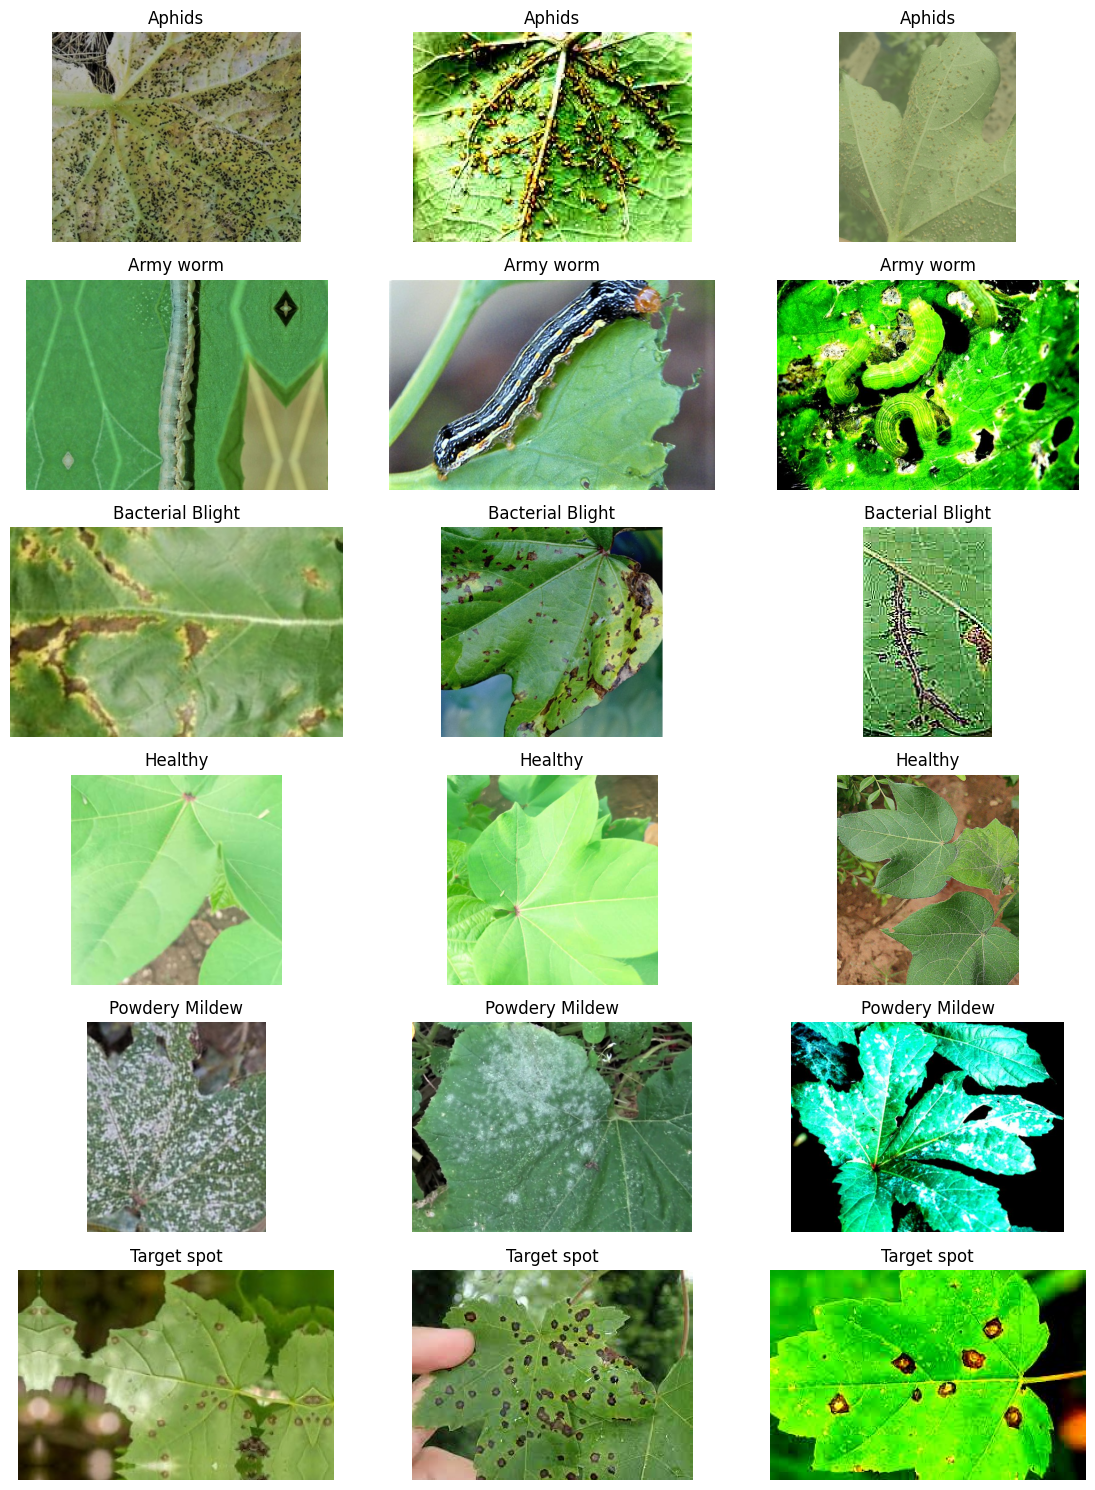

In [ ]:
import os
import matplotlib.pyplot as plt

# Dataset path
dataset_path = "/content/train"

# Number of samples per label
num_samples_per_label = 3

# Ensure dataset path exists and folders are present
if not os.path.exists(dataset_path):
    print("Error: Dataset path", dataset_path, "does not exist.")
    exit(1)

labels = ["Aphids", "Army worm", "Bacterial Blight", "Healthy", "Powdery Mildew", "Target spot"]
for label in labels:
    label_path = os.path.join(dataset_path, label)
    if not os.path.isdir(label_path):
        print("Error: Label folder", label_path, "does not exist.")
        exit(1)

    # Check if there are enough images in the folder
    image_files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]
    if len(image_files) < num_samples_per_label:
        print("Warning:", label, "folder has less than", num_samples_per_label, "images. Using available images.")
        num_samples_per_label = len(image_files)  # Adjust based on available images

# Create a grid layout with space between rows
rows, cols = 6, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 15))  # Adjust figure size as needed
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between rows

# Loop through labels and images, displaying them
index = 0
for label in labels:
    label_path = os.path.join(dataset_path, label)
    image_files = [os.path.join(label_path, f) for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]

    for i in range(num_samples_per_label):
        if i >= len(image_files):
            break  # Handle cases where there are less than desired images

        image = plt.imread(image_files[i])
        axes[index // cols, index % cols].imshow(image)
        axes[index // cols, index % cols].set_title(label)
        axes[index // cols, index % cols].axis('off')
        index += 1

# Tight layout for better spacing within subplots
plt.tight_layout()

# Show the visualization
plt.show()
